In [1]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from keras.preprocessing.text import Tokenizer, text_to_word_sequence  
from sklearn.model_selection import train_test_split  

from google.colab import files
import numpy as np               
import pandas as pd              
import matplotlib.pyplot as plt  
import os                        
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -R /content/texts # проверяем наличие папки texts; если есть, удаляем ее

rm: cannot remove '/content/texts': No such file or directory


In [4]:
# указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/datasets/texts/Тексты писателей.zip' -d /content/texts 

In [5]:
def readText(fileName):          
  f = open(fileName, 'r')        
  text = f.read()                
  text = text.replace("\n", " ") 
  return text                   

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"]
nClasses = len(className)  

In [18]:
# загружаем обучающие тексты
trainText = []  # формируем обучающие тексты
testText = []   # формируем тестовые тексты

for i in className:              # проходим по каждому классу
  for j in os.listdir('texts/'): # проходим по каждому файлу в папке с текстами
    if i in j:                   # проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j:                       # если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) # добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') # выводим информацию
      if 'Тестовая' in j:                        # если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j))  # добавляем в тестовую выборку
        print(j, 'добавлен в тестовую выборку')  # выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [19]:
maxWordsCount = 20000 
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', 
                      lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)          
items = list(tokenizer.word_index.items()) 
print(len(trainText))
print(len(trainText[0]))

6
1049517


In [20]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тексты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тексты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[0][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')
print(len(trainWordIndexes))    # количество элементов в trainText
print(len(trainWordIndexes[0])) 

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               «Лиса-на-рассвете»   Коралио нежился в полуденном зное, как томная красавица в сурово х
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 

6
160607


In [21]:
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # идём по всей длине вектора индексов
  # "откусываем" векторы длины xLen и смещаемся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [22]:
 # функция принимает последовательность индексов, размер окна, шаг окна
def createSetsMultiClasses(wordIndexes, xLen, step):

  # для каждого из 6 классов создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes)
  classesXSamples = [] 
  for wI in wordIndexes: 
    classesXSamples.append(getSetFromIndexes(wI, xLen, step))

  # формируем один общий xSamples
  xSamples = []
  ySamples = []
  
  for t in range(nClasses):   
    xT = classesXSamples[t]   
    for i in range(len(xT)):  
      xSamples.append(xT[i])  
    
    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses)
    for i in range(len(xT)):  
      ySamples.append(currY)  
 # переводим в массив numpy для подачи в нейронку
  xSamples = np.array(xSamples)
  # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) 
  # функция возвращает выборку и соответствующие векторы классов
  return (xSamples, ySamples)   

In [23]:
# задаём базовые параметры
xLen = 1000 # длина отрезка текста, по которой анализируем, в словах
step = 100  # шаг разбиения исходного текста на обучающие вектора

In [25]:
# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)


(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)


In [33]:
# Embedding + Dense сеть
model = Sequential()
model.add(Embedding(maxWordsCount, 50, input_length = xLen))
model.add(SpatialDropout1D(0.2))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 1000, 50)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 50000)             0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 50000)             200000    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               6400128   
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                

Epoch 1/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0600 - accuracy: 0.9925 - val_loss: 2.8689 - val_accuracy: 0.7190
Epoch 2/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0582 - accuracy: 0.9926 - val_loss: 3.1948 - val_accuracy: 0.6986
Epoch 3/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0593 - accuracy: 0.9921 - val_loss: 3.4160 - val_accuracy: 0.6832
Epoch 4/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0745 - accuracy: 0.9917 - val_loss: 3.0522 - val_accuracy: 0.7166
Epoch 5/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0689 - accuracy: 0.9925 - val_loss: 3.1129 - val_accuracy: 0.7278
Epoch 6/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0760 - accuracy: 0.9914 - val_loss: 2.8635 - val_accuracy: 0.7421
Epoch 7/15
552/552 [==============================] - 8s 14ms/step - loss: 0.0793 - accuracy: 0.9910 - val_loss: 3.0214 - val_accuracy: 0.7279

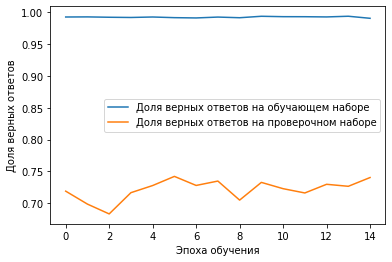

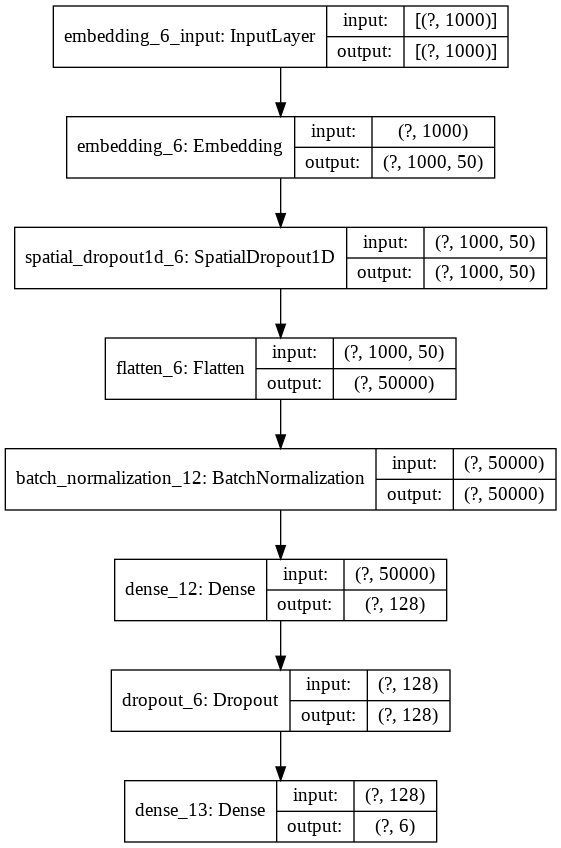

In [36]:
history = model.fit(xTrain, 
                      yTrain, 
                      epochs=15,
                      batch_size=32,
                      validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
plot_model(model, show_shapes=True, show_layer_names=True)

In [40]:
# Embedding + LSTM сеть
model1 = Sequential()
model1.add(Embedding(maxWordsCount, 10, input_length = xLen))
model1.add(SpatialDropout1D(0.2))
model1.add(BatchNormalization())
model1.add(LSTM(16, activation='relu', return_sequences=True))
model1.add(LSTM(16, activation='relu', return_sequences=True))
model1.add(Flatten())
model1.add(BatchNormalization())
model1.add(Dense(6, activation='softmax'))

model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])   
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 1000, 10)          40        
_________________________________________________________________
lstm_4 (LSTM)                (None, 1000, 16)          1728      
_________________________________________________________________
lstm_5 (LSTM)                (None, 1000, 16)          2112      
_________________________________________________________________
flatten_9 (Flatten)          (None, 16000)             0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16000)            

Epoch 1/5
138/138 [==============================] - 379s 3s/step - loss: 0.4250 - accuracy: 0.8437 - val_loss: 2.0073 - val_accuracy: 0.1968
Epoch 2/5
138/138 [==============================] - 378s 3s/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 4.2970 - val_accuracy: 0.1611
Epoch 3/5
138/138 [==============================] - 379s 3s/step - loss: 0.0307 - accuracy: 0.9910 - val_loss: 9.0426 - val_accuracy: 0.1611
Epoch 4/5
138/138 [==============================] - 372s 3s/step - loss: 0.0229 - accuracy: 0.9931 - val_loss: 7.3477 - val_accuracy: 0.3118
Epoch 5/5
138/138 [==============================] - 363s 3s/step - loss: 0.0258 - accuracy: 0.9930 - val_loss: 5.9228 - val_accuracy: 0.4080


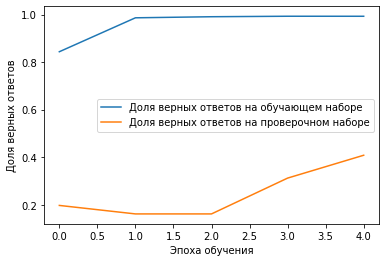

In [41]:
history = model1.fit(xTrain, 
                    yTrain, 
                    epochs=5,
                    batch_size=128,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plot_model(model1, show_shapes=True, show_layer_names=True)
plt.show()

In [42]:
# Embedding + Conv1D сеть
model2 = Sequential()
model2.add(Embedding(maxWordsCount, 30, input_length = xLen))

model2.add(Conv1D(256, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(6, activation='sigmoid'))
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 30)          600000    
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 256)          38656     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 256)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 199, 256)          0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 199, 256)          1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)         

Epoch 1/15
552/552 [==============================] - 7s 14ms/step - loss: 0.3087 - accuracy: 0.8836 - val_loss: 5.6861 - val_accuracy: 0.3862
Epoch 2/15
552/552 [==============================] - 7s 13ms/step - loss: 0.0262 - accuracy: 0.9949 - val_loss: 2.9032 - val_accuracy: 0.7176
Epoch 3/15
552/552 [==============================] - 7s 13ms/step - loss: 0.0285 - accuracy: 0.9950 - val_loss: 3.1826 - val_accuracy: 0.7291
Epoch 4/15
552/552 [==============================] - 7s 13ms/step - loss: 0.0290 - accuracy: 0.9949 - val_loss: 2.2164 - val_accuracy: 0.7733
Epoch 5/15
552/552 [==============================] - 7s 13ms/step - loss: 0.0224 - accuracy: 0.9964 - val_loss: 1.7469 - val_accuracy: 0.8162
Epoch 6/15
552/552 [==============================] - 7s 13ms/step - loss: 0.0239 - accuracy: 0.9963 - val_loss: 2.4670 - val_accuracy: 0.7828
Epoch 7/15
552/552 [==============================] - 7s 13ms/step - loss: 0.0253 - accuracy: 0.9969 - val_loss: 2.8990 - val_accuracy: 0.7453

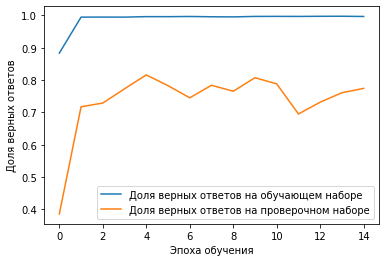

In [43]:
history = model2.fit(xTrain, 
                      yTrain, 
                      epochs=15,
                      batch_size=32,
                      validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plot_model(model2, show_shapes=True, show_layer_names=True)
plt.show()

In [45]:
# Embedding + сложная сеть из Dense, LSTM и Conv1D
model3 = Sequential()
model3.add(Embedding(maxWordsCount, 50, input_length=xLen))
model3.add(SpatialDropout1D(0.2))

model3.add(Conv1D(64, 3, padding='same', activation="relu"))
model3.add(MaxPooling1D(2))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Conv1D(64, 3, padding='same', activation="relu"))
model3.add(MaxPooling1D(2))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

model3.add(Conv1D(64, 3, padding='same', activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model3.add(MaxPooling1D(2))
model3.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model3.add(BatchNormalization())             # добавляем слой нормализации данных

model3.add(LSTM(8, return_sequences=1))      # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model3.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model3.add(BatchNormalization())             # добавляем слой нормализации данных

model3.add(Dense(256, activation='relu'))    # добавляем полносвязный слой с указанием количества нейронов и функции активации
model3.add(Dropout(0.2))
model3.add(Flatten())                        # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)

model3.add(Dense(6, activation='softmax'))   # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1000, 64)          9664      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 500, 64)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 500, 64)           256       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 500, 64)         

Epoch 1/10
276/276 [==============================] - 8s 30ms/step - loss: 0.5387 - accuracy: 0.8185 - val_loss: 9.0670 - val_accuracy: 0.1968
Epoch 2/10
276/276 [==============================] - 8s 28ms/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 3.5038 - val_accuracy: 0.3964
Epoch 3/10
276/276 [==============================] - 8s 28ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 2.1394 - val_accuracy: 0.6197
Epoch 4/10
276/276 [==============================] - 8s 28ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 3.5259 - val_accuracy: 0.5749
Epoch 5/10
276/276 [==============================] - 8s 28ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 1.3730 - val_accuracy: 0.7176
Epoch 6/10
276/276 [==============================] - 8s 29ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 2.3186 - val_accuracy: 0.6506
Epoch 7/10
276/276 [==============================] - 8s 28ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 2.7650 - val_accuracy: 0.6753

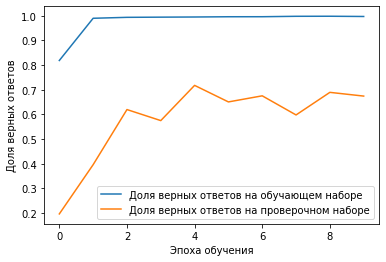

In [46]:
history = model3.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plot_model(model3, show_shapes=True, show_layer_names=True)
plt.show()